In [ ]:
# Input Configuration
from pathlib import Path

INPUT_PATH = Path("data/user_access_log.csv")
OUTPUT_DIR = Path("outputs")
AS_OF_DATE = None

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [ ]:

# Automated User Access Analytics for IT Audit

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

plt.style.use("default")

# 2. Load Data
# This notebook expects a CSV at INPUT_PATH (see config cell above)
if not INPUT_PATH.exists():
    raise FileNotFoundError(
        f"Input file not found: {INPUT_PATH}. "
        "Create a 'data/' folder and place your CSV there (e.g. data/user_access_log.csv)."
    )

df = pd.read_csv(INPUT_PATH)
print(f"Loaded file: {INPUT_PATH}  |  shape: {df.shape}")

# Display info
print("Dataset shape:", df.shape)
df.head()

📂 Please upload the CSV file you want to analyze...


Saving user_access_log.csv to user_access_log.csv
✅ Loaded file: user_access_log.csv
Dataset shape: (10, 9)


,user_id,full_name,role,department,is_privileged,last_login_date,failed_login_attempts,login_time_hour,location
0,U001,Samir Patel,System Admin,IT,1,2025-02-10,7,23,Head Office
1,U002,Ayesha Khan,Business Analyst,Finance,0,2025-11-25,1,10,Head Office
2,U003,John Smith,Developer,IT,0,2025-08-15,4,19,Remote
3,U004,Linda Mokoena,DBA,IT,1,2025-06-01,2,2,Data Centre
4,U005,Michael Green,AP Clerk,Finance,0,2025-03-30,6,21,Branch A


In [ ]:
# 3. Basic Cleaning & Type Conversion

# Convert last_login_date to datetime if column exists
if 'last_login_date' in df.columns:
    df['last_login_date'] = pd.to_datetime(df['last_login_date'], errors='coerce')
else:
    print("Column 'last_login_date' not found — skipping datetime conversion.")

# Ensure is_privileged is numeric (0/1)
if 'is_privileged' in df.columns:
    df['is_privileged'] = pd.to_numeric(df['is_privileged'], errors='coerce').fillna(0).astype(int)
else:
    print("Column 'is_privileged' not found — skipping conversion.")

# Make sure failed_login_attempts is numeric
if 'failed_login_attempts' in df.columns:
    df['failed_login_attempts'] = pd.to_numeric(df['failed_login_attempts'], errors='coerce').fillna(0).astype(int)
else:
    print("Column 'failed_login_attempts' not found — skipping conversion.")

# Make sure login_time_hour is numeric
if 'login_time_hour' in df.columns:
    df['login_time_hour'] = pd.to_numeric(df['login_time_hour'], errors='coerce').fillna(0).astype(int)
else:
    print("Column 'login_time_hour' not found — skipping conversion.")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                10 non-null     object        
 1   full_name              10 non-null     object        
 2   role                   10 non-null     object        
 3   department             10 non-null     object        
 4   is_privileged          10 non-null     int64         
 5   last_login_date        10 non-null     datetime64[ns]
 6   failed_login_attempts  10 non-null     int64         
 7   login_time_hour        10 non-null     int64         
 8   location               10 non-null     object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 852.0+ bytes


,user_id,full_name,role,department,is_privileged,last_login_date,failed_login_attempts,login_time_hour,location
0,U001,Samir Patel,System Admin,IT,1,2025-02-10,7,23,Head Office
1,U002,Ayesha Khan,Business Analyst,Finance,0,2025-11-25,1,10,Head Office
2,U003,John Smith,Developer,IT,0,2025-08-15,4,19,Remote
3,U004,Linda Mokoena,DBA,IT,1,2025-06-01,2,2,Data Centre
4,U005,Michael Green,AP Clerk,Finance,0,2025-03-30,6,21,Branch A


In [ ]:
# 4. Create Risk Flags

# 4.1 Dormant account flag (no login in last 90 days)
today = pd.Timestamp('today').normalize()
df['days_since_last_login'] = (today - df['last_login_date']).dt.days

DORMANT_THRESHOLD = 90
df['is_dormant'] = (df['days_since_last_login'] > DORMANT_THRESHOLD).astype(int)

# 4.2 Unusual login time (outside normal business hours: 7 to 19)
df['is_unusual_login_time'] = ~df['login_time_hour'].between(7, 19)
df['is_unusual_login_time'] = df['is_unusual_login_time'].astype(int)

# 4.3 Many failed login attempts (e.g. > 5)
FAILED_THRESHOLD = 5
df['is_many_failed_logins'] = (df['failed_login_attempts'] >= FAILED_THRESHOLD).astype(int)

df[['user_id', 'days_since_last_login', 'is_dormant',
    'is_unusual_login_time', 'is_many_failed_logins']].head()

,user_id,days_since_last_login,is_dormant,is_unusual_login_time,is_many_failed_logins
0,U001,296,1,1,1
1,U002,8,0,0,0
2,U003,110,1,0,0
3,U004,185,1,1,0
4,U005,248,1,1,1


In [ ]:
# 5. Simple Risk Scoring

# Risk scoring performed based on account and account activity
df['risk_score'] = 0
df['risk_score'] += df['is_privileged'] * 3
df['risk_score'] += df['is_dormant'] * 2
df['risk_score'] += df['is_many_failed_logins'] * 2
df['risk_score'] += df['is_unusual_login_time'] * 1

def map_risk_level(score):
    if score >= 6:
        return "High"
    elif score >= 3:
        return "Medium"
    else:
        return "Low"

df['risk_level'] = df['risk_score'].apply(map_risk_level)

df[['user_id', 'role', 'is_privileged', 'is_dormant',
    'is_many_failed_logins', 'is_unusual_login_time',
    'risk_score', 'risk_level']].sort_values('risk_score', ascending=False)

,user_id,role,is_privileged,is_dormant,is_many_failed_logins,is_unusual_login_time,risk_score,risk_level
0,U001,System Admin,1,1,1,1,8,High
3,U004,DBA,1,1,0,1,6,High
5,U006,Security Admin,1,1,0,0,5,Medium
4,U005,AP Clerk,0,1,1,1,5,Medium
7,U008,Vendor Manager,0,1,1,0,4,Medium
8,U009,IT Support,0,0,1,1,3,Medium
9,U010,Finance Manager,0,1,0,0,2,Low
2,U003,Developer,0,1,0,0,2,Low
1,U002,Business Analyst,0,0,0,0,0,Low
6,U007,Sales Rep,0,0,0,0,0,Low


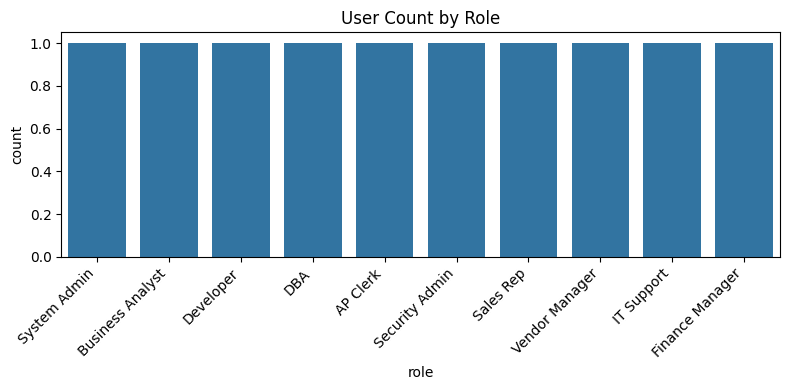

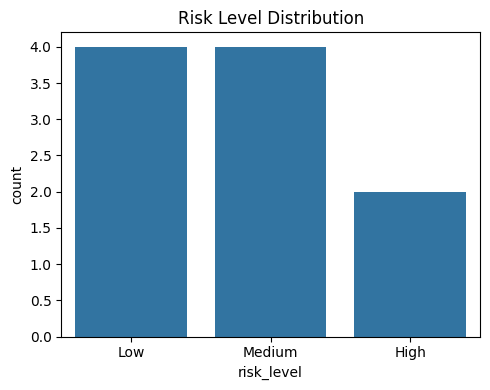

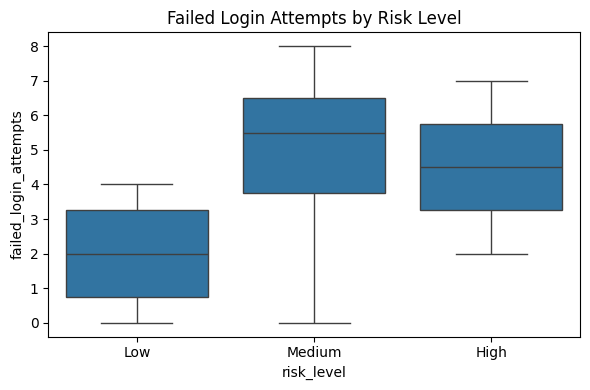

In [ ]:
# 6. Exploratory Visuals

# 6.1 Count of users by role
plt.figure(figsize=(8, 4))
sns.countplot(x='role', data=df)
plt.xticks(rotation=45, ha='right')
plt.title("User Count by Role")
plt.tight_layout()
plt.show()

# 6.2 Risk level distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='risk_level', data=df, order=['Low', 'Medium', 'High'])
plt.title("Risk Level Distribution")
plt.tight_layout()
plt.show()

# 6.3 Boxplot for failed login attempts by risk level
plt.figure(figsize=(6, 4))
sns.boxplot(x='risk_level', y='failed_login_attempts',
            data=df, order=['Low', 'Medium', 'High'])
plt.title("Failed Login Attempts by Risk Level")
plt.tight_layout()
plt.show()


In [ ]:
# 7. Optional: Anomaly Detection with Isolation Forest

# Select numerical features for anomaly detection
features = df[['failed_login_attempts', 'days_since_last_login',
               'login_time_hour', 'is_privileged']].copy()

# Fit Isolation Forest
iso = IsolationForest(contamination=0.15, random_state=42)
df['anomaly_flag'] = iso.fit_predict(features)

# In IsolationForest: -1 = anomaly, 1 = normal
df['is_anomaly'] = (df['anomaly_flag'] == -1).astype(int)

df[['user_id', 'failed_login_attempts', 'days_since_last_login',
    'login_time_hour', 'is_privileged', 'is_anomaly']].head(10)

,user_id,failed_login_attempts,days_since_last_login,login_time_hour,is_privileged,is_anomaly
0,U001,7,296,23,1,1
1,U002,1,8,10,0,0
2,U003,4,110,19,0,0
3,U004,2,185,2,1,1
4,U005,6,248,21,0,0
5,U006,0,348,9,1,0
6,U007,3,5,11,0,0
7,U008,8,242,16,0,0
8,U009,5,54,6,0,0
9,U010,0,383,15,0,0


In [ ]:
# 8. Combine Rule-based Risk and Anomalies into Final View

df['final_high_risk'] = ((df['risk_level'] == 'High') | (df['is_anomaly'] == 1)).astype(int)

high_risk_users = df[df['final_high_risk'] == 1].copy()

high_risk_users = high_risk_users[[
    'user_id', 'full_name', 'role', 'department', 'location',
    'is_privileged', 'days_since_last_login', 'is_dormant',
    'failed_login_attempts', 'is_many_failed_logins',
    'login_time_hour', 'is_unusual_login_time',
    'risk_score', 'risk_level', 'is_anomaly'
]].sort_values(['risk_level', 'risk_score'], ascending=[False, False])

high_risk_users

,user_id,full_name,role,department,location,is_privileged,days_since_last_login,is_dormant,failed_login_attempts,is_many_failed_logins,login_time_hour,is_unusual_login_time,risk_score,risk_level,is_anomaly
0,U001,Samir Patel,System Admin,IT,Head Office,1,296,1,7,1,23,1,8,High,1
3,U004,Linda Mokoena,DBA,IT,Data Centre,1,185,1,2,0,2,1,6,High,1


In [ ]:
# 9. Simple Audit Report Style Summary Tables

# 9.1 Summary of key metrics
summary = {
    "Total users": [len(df)],
    "Privileged accounts": [df['is_privileged'].sum()],
    "Dormant accounts": [df['is_dormant'].sum()],
    "Users with many failed logins": [df['is_many_failed_logins'].sum()],
    "High risk users (score-based)": [(df['risk_level'] == 'High').sum()],
    "Anomaly-flagged users": [df['is_anomaly'].sum()]
}
pd.DataFrame(summary).T.rename(columns={0: "Count"})

,Count
Total users,10
Privileged accounts,3
Dormant accounts,7
Users with many failed logins,4
High risk users (score-based),2
Anomaly-flagged users,2


In [ ]:
# 9.2 Risk by department
risk_by_dept = df.groupby(['department', 'risk_level'])['user_id'].count().unstack(fill_value=0)
risk_by_dept

risk_level,High,Low,Medium
department,,,
Finance,0,2,1
IT,2,1,2
Procurement,0,0,1
Sales,0,1,0


In [ ]:
# 10. Export high-risk users to file(s)

csv_path = OUTPUT_DIR / "high_risk_users_report.csv"
high_risk_users.to_csv(csv_path, index=False)
print(f"Saved CSV report to: {csv_path.resolve()}")

# Optional: also save a lightweight Excel file (audit-friendly for reviewers)
xlsx_path = OUTPUT_DIR / "high_risk_users_report.xlsx"
high_risk_users.to_excel(xlsx_path, index=False)
print(f"Saved Excel report to: {xlsx_path.resolve()}")


File saved as: high_risk_users_report.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download prompt sent — check your browser downloads.


In [ ]:
import pandas as pd
# Audit friendly output of high risk users

# 1. Make column names report-friendly
rename_map = {
    "user_id": "User ID",
    "full_name": "Full Name",
    "role": "Role",
    "department": "Department",
    "is_privileged": "Privileged User",
    "last_login_date": "Last Login Date",
    "failed_login_attempts": "Failed Login Attempts",
    "login_time_hour": "Login Hour (24h)",
    "location": "Location",
    # Optional – only used if it exists:
    "risk_score": "Risk Score",
    "anomaly_flag": "Anomaly Flag"
}

report_df = high_risk_users.rename(columns={k: v for k, v in rename_map.items() if k in high_risk_users.columns})

output_file = "High_Risk_User_Access_Report.xlsx"

with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    # 2. Write to Excel
    sheet_name = "High Risk Users"
    report_df.to_excel(writer, sheet_name=sheet_name, index=False)

    workbook  = writer.book
    worksheet = writer.sheets[sheet_name]

    # 3. Header style
    header_format = workbook.add_format({
        "bold": True,
        "bg_color": "#1F4E78",      # dark blue
        "font_color": "white",
        "align": "center",
        "valign": "vcenter",
        "border": 1
    })

    for col_num, value in enumerate(report_df.columns.values):
        worksheet.write(0, col_num, value, header_format)

    # 4. Auto column widths & basic body format
    body_format = workbook.add_format({
        "border": 1,
        "valign": "top"
    })

    for col_idx, col in enumerate(report_df.columns):
        # Auto width based on content
        max_len = max(
            report_df[col].astype(str).map(len).max(),
            len(col)
        )
        max_len = min(max_len + 2, 40)
        worksheet.set_column(col_idx, col_idx, max_len, body_format)

    # 5. Date format for Last Login Date
    if "Last Login Date" in report_df.columns:
        date_format = workbook.add_format({
            "num_format": "yyyy-mm-dd",
            "border": 1
        })
        col_idx = report_df.columns.get_loc("Last Login Date")
        worksheet.set_column(col_idx, col_idx, 15, date_format)

    # 6. Integer format for numeric columns
    int_format = workbook.add_format({
        "num_format": "0",
        "border": 1
    })

    for col_name in ["Failed Login Attempts", "Login Hour (24h)"]:
        if col_name in report_df.columns:
            col_idx = report_df.columns.get_loc(col_name)
            worksheet.set_column(col_idx, col_idx, 20, int_format)

    # 7. Conditional formatting for Risk Score (if present)
    if "Risk Score" in report_df.columns:
        col_idx = report_df.columns.get_loc("Risk Score")
        col_letter = chr(ord("A") + col_idx)
        row_start = 2  # row 2 in Excel (1-based), since row 1 is header
        row_end = len(report_df) + 1

        high_risk_format = workbook.add_format({
            "bg_color": "#FFC7CE",   # light red
            "border": 1
        })

        worksheet.conditional_format(
            f"{col_letter}{row_start}:{col_letter}{row_end}",
            {
                "type": "cell",
                "criteria": ">=",
                "value": 80,
                "format": high_risk_format
            }
        )

    # 8. Freeze header row & add filters
    worksheet.freeze_panes(1, 0)  # freeze top row
    worksheet.autofilter(0, 0, len(report_df), len(report_df.columns) - 1)

print(f"Exported styled Excel report to: {output_file}")

Exported styled Excel report to: High_Risk_User_Access_Report.xlsx
